<a href="https://colab.research.google.com/github/BhanuMythreyi/Fraudulent-Job-Posting-detector/blob/main/Fraudulent_Job_Post_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wordcloud

In [ ]:
!pip install -U spacy

     |████████████████████████████████| 6.0 MB 13.9 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 451 kB 60.2 MB/s 
     |████████████████████████████████| 181 kB 68.3 MB/s 
     |████████████████████████████████| 10.1 MB 58.3 MB/s 
     |████████████████████████████████| 628 kB 58.3 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [ ]:
import re
import string
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score,plot_confusion_matrix,classification_report,confusion_matrix
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [ ]:
# extracting the compressed dataset
from zipfile import ZipFile
dataset = '/content/fake_job_postings.csv.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()

In [ ]:
df = pd.read_csv(dataset)
df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


In [ ]:
# Checking the number of rows and columns (rows,columns)
df.shape

(17880, 18)

In [ ]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [ ]:
# Now dropping the columns that cannot be used to describe whether the jobis real or fake
col = ['job_id','telecommuting','has_company_logo','has_questions','salary_range','employment_type']
for c in col:
  del df[c]

In [ ]:
df

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Sales,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,Mid-Senior level,NaN,Computer Software,Sales,0
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,NaN,NaN,NaN,NaN,0
17878,Graphic Designer,"NG, LA, Lagos",NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,Not Applicable,Professional,Graphic Design,Design,0


In [ ]:
# Handling the null values
df.fillna('',inplace=True)

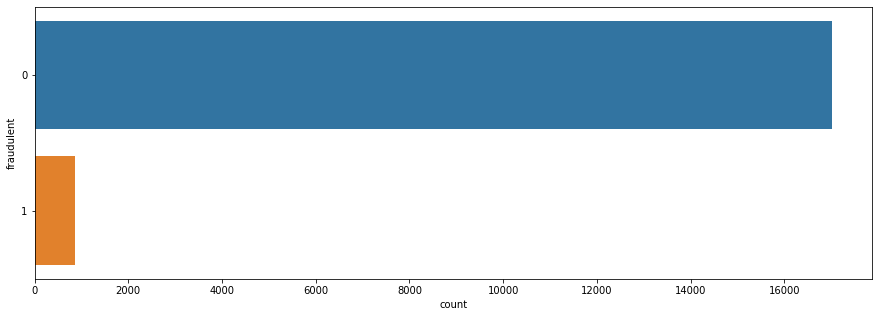

In [ ]:
plt.figure(figsize = (15,5))
sns.countplot(y='fraudulent',data=df)
plt.show()
# Below the orange colour bar represents fraudulent and the blue color bar represents true or non-fraudulent jobs

In [ ]:
# Number of fraudulent and non fraudulent job postings
df.groupby('fraudulent')['fraudulent'].count()

fraudulent
0    17014
1      866
Name: fraudulent, dtype: int64

In [ ]:
# Relationship between Number of jobs posted and experience, here we delete the data where there is a blank in place of experience
exp = dict(df.required_experience.value_counts())
del exp['']

In [ ]:
exp

{'Associate': 2297,
 'Director': 389,
 'Entry level': 2697,
 'Executive': 141,
 'Internship': 381,
 'Mid-Senior level': 3809,
 'Not Applicable': 1116}

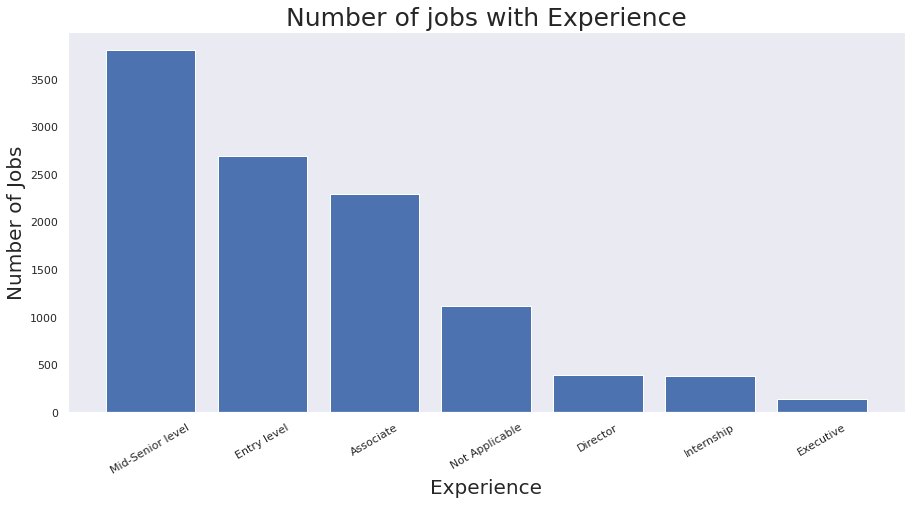

In [ ]:
plt.figure(figsize=(15,7))
sns.set_theme(style='dark')
plt.bar(exp.keys(),exp.values())
plt.title('Number of jobs with Experience',size=25)
plt.xlabel('Experience',size=20)
plt.ylabel('Number of Jobs',size=20)
plt.xticks(rotation=30)
plt.show()

In [ ]:
# Creating a column for country
def CountryGiver(location):
  arr = location.split(',')
  return arr[0]

df['country'] = df.location.apply(CountryGiver)

In [ ]:
df

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Sales,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,Mid-Senior level,,Computer Software,Sales,0,CA
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,US
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,,,,,0,US
17878,Graphic Designer,"NG, LA, Lagos",,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,Not Applicable,Professional,Graphic Design,Design,0,NG


In [ ]:
# Visualizing the data for which most jobs are posted in the current dataset
coun = dict(df.country.value_counts()[:20])
del coun['']
coun

{'AU': 214,
 'BE': 117,
 'CA': 457,
 'DE': 383,
 'EE': 72,
 'ES': 66,
 'FR': 70,
 'GB': 2384,
 'GR': 940,
 'HK': 77,
 'IE': 114,
 'IL': 72,
 'IN': 276,
 'NL': 127,
 'NZ': 333,
 'PH': 132,
 'PL': 76,
 'SG': 80,
 'US': 10656}

Text(0.5, 0, 'Countries')

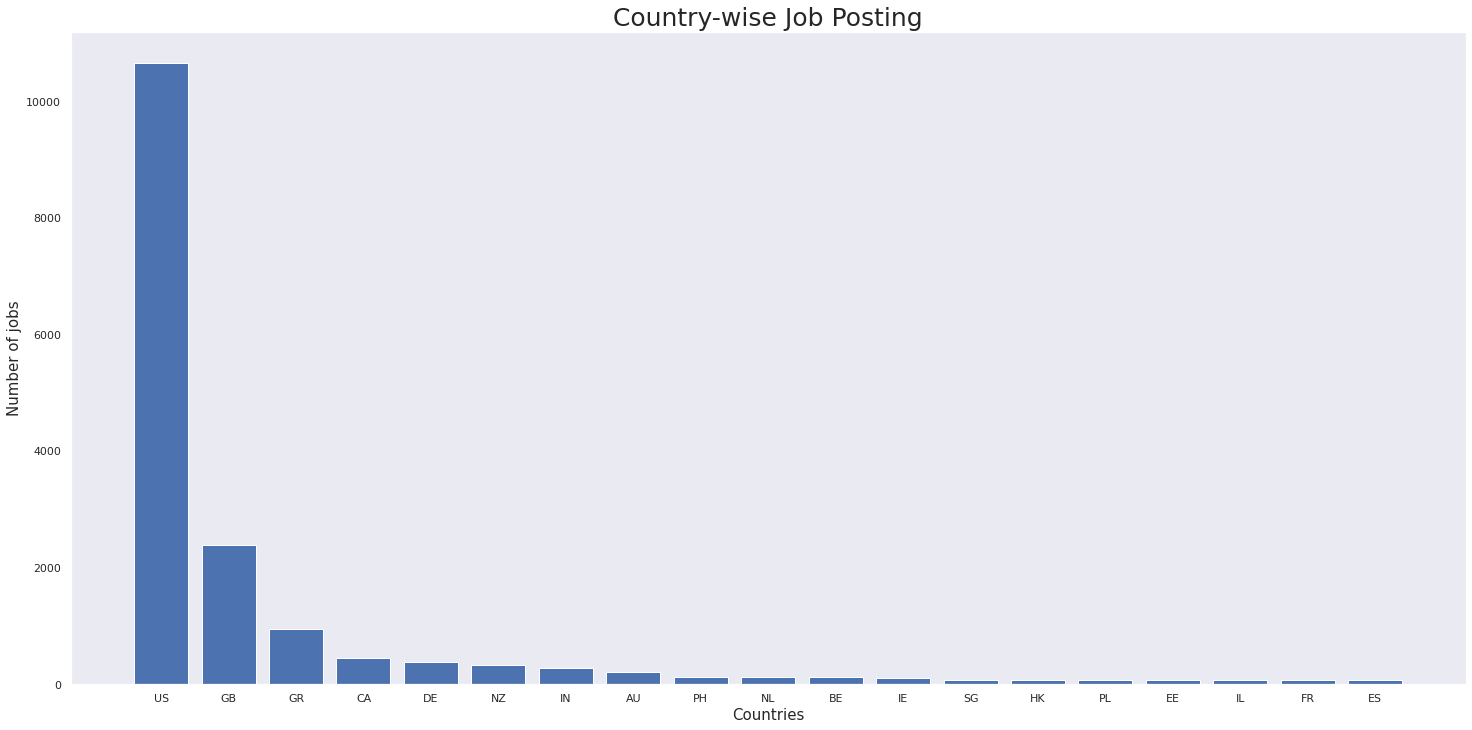

In [ ]:
plt.figure(figsize=(25,12))
plt.title('Country-wise Job Posting',size=25)
plt.bar(coun.keys(),coun.values())
plt.ylabel('Number of jobs',size=15)
plt.xlabel('Countries',size=15)

In [ ]:
# Relation between the qualification/education and number of jobs
ed = dict(df.required_education.value_counts()[:10])
del ed['']
ed

{'Associate Degree': 274,
 "Bachelor's Degree": 5145,
 'Certification': 170,
 'High School or equivalent': 2080,
 "Master's Degree": 416,
 'Professional': 74,
 'Some College Coursework Completed': 102,
 'Unspecified': 1397,
 'Vocational': 49}

Text(0, 0.5, 'Number of jobs')

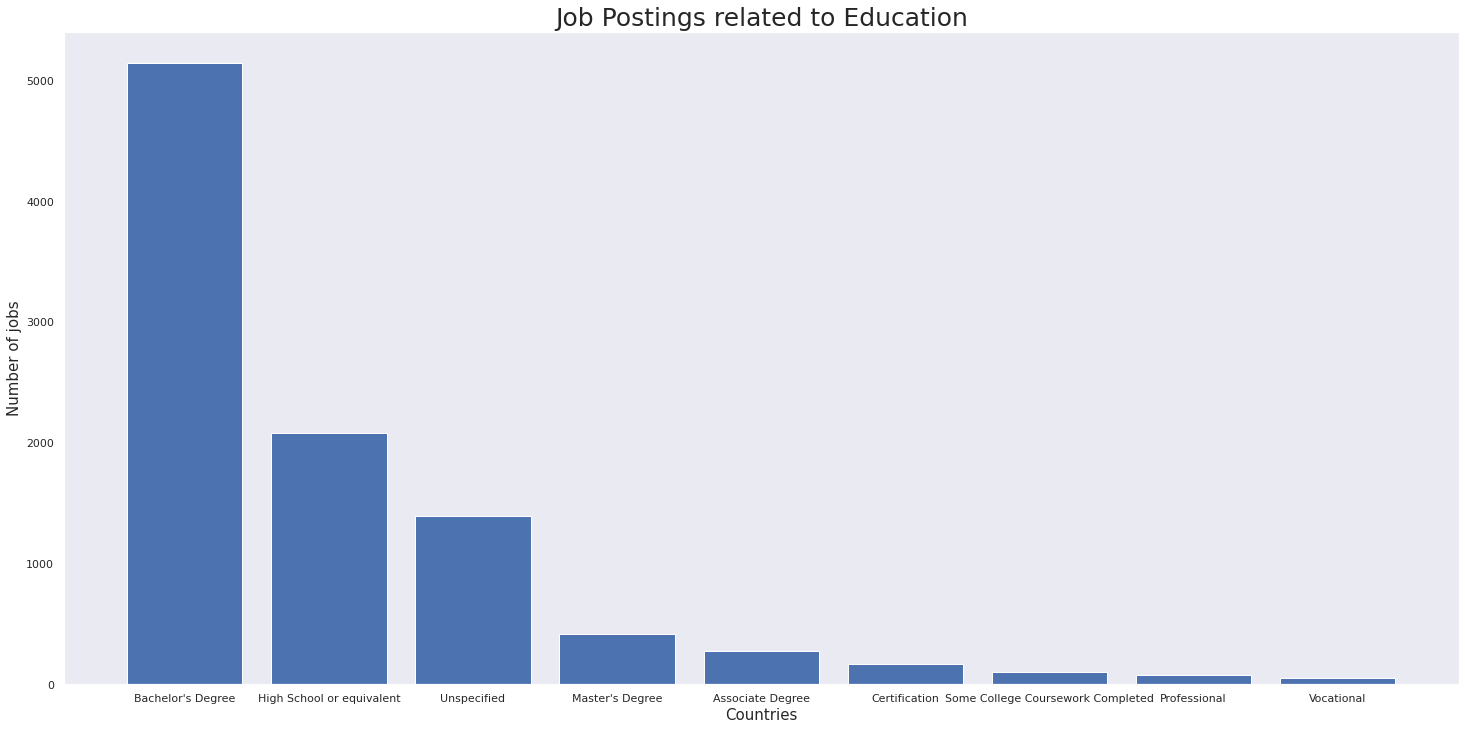

In [ ]:
plt.figure(figsize=(25,12))
plt.title('Job Postings related to Education',size=25)
plt.bar(ed.keys(),ed.values())
plt.xlabel('Countries',size=15)
plt.ylabel('Number of jobs',size=15)

In [ ]:
# Analysing the True or Non-fraudulent job titles
print(df[df.fraudulent==0].title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        73
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


In [ ]:
# Analysing the fraudulent job titles
print(df[df.fraudulent==1].title.value_counts()[:10])

Data Entry Admin/Clerical Positions - Work From Home                    21
Home Based Payroll Typist/Data Entry Clerks Positions Available         21
Cruise Staff Wanted *URGENT*                                            21
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Account Sales Managers $80-$130,000/yr                                  10
Network Marketing                                                       10
Payroll Clerk                                                           10
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Name: title, dtype: int64


In [ ]:
df['combined']=df['title']+df['company_profile']+df['description']+df['requirements']+df['benefits']
del df['title']
del df['location']
del df['department']
del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']
del df['required_experience']
del df['required_education']
del df['industry']
del df['function']
del df['country']

In [ ]:
df

,fraudulent,combined
0,0,"Marketing InternWe're Food52, and we've create..."
1,0,Customer Service - Cloud Video Production90 Se...
2,0,Commissioning Machinery Assistant (CMA)Valor S...
3,0,Account Executive - Washington DCOur passion f...
4,0,Bill Review ManagerSpotSource Solutions LLC is...
...,...,...
17875,0,Account Director - Distribution Vend is lookin...
17876,0,Payroll AccountantWebLinc is the e-commerce pl...
17877,0,Project Cost Control Staff Engineer - Cost Con...
17878,0,Graphic DesignerNemsia Studios is looking for ...


In [ ]:
fraudjobs_text = df[df.fraudulent==1].combined
nonfraudjobs_text = df[df.fraudulent==0].combined

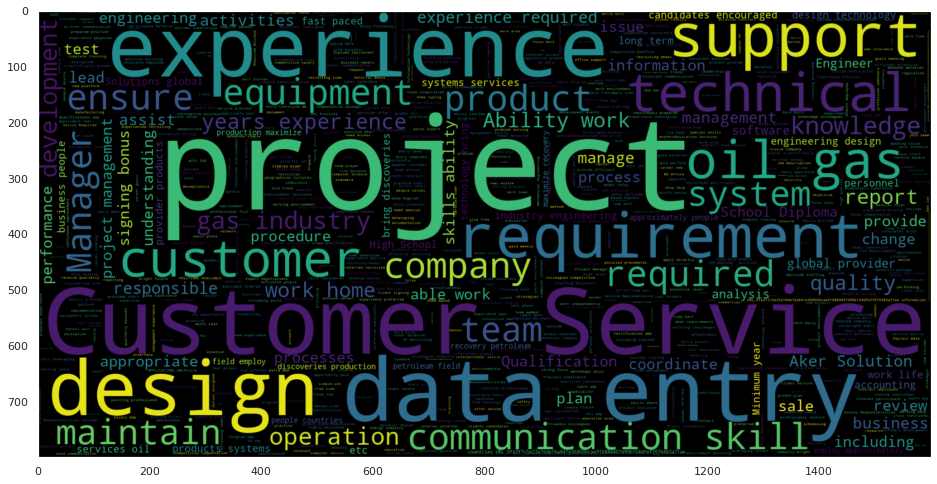

In [ ]:
# Creating a word cloud for fraudulent jobs
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize=(16,14))
wc = WordCloud(min_font_size = 3,max_words = 3000,width = 1600,height = 800,stopwords=STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation='bilinear')

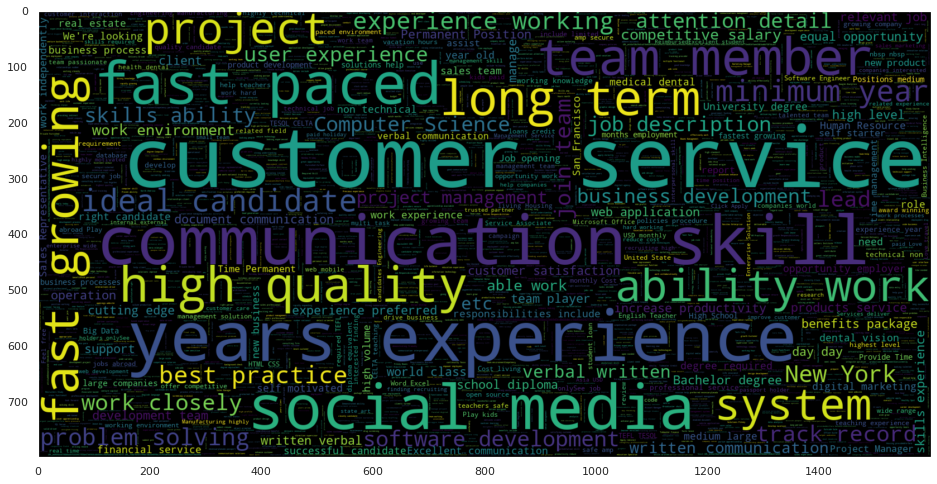

In [ ]:
# Creating a word cloud for non-fraudulent jobs
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize=(16,14))
wc = WordCloud(min_font_size = 3,max_words = 3000,width = 1600,height = 800,stopwords=STOPWORDS).generate(str(" ".join(nonfraudjobs_text)))
plt.imshow(wc,interpolation='bilinear')

In [ ]:
# Working with natural language processing
!pip install spacy && python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.9 MB 12.7 MB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# Preprocessing the data
punctuations = string.punctuation
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

parser = English()
def spacy_tokenizer(sentence):
  mytokens = parser(sentence)

  mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]

  mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations] 

  return mytokens

def clean_text(combined):
  return combined.strip().lower()


class predictors(TransformerMixin):
  def transform(self,X,**transform_params):
    return [clean_text(combined) for combined in X]

  def fit(self,X,y=None,**fit_params):
    return self

  def get_params(self,deep=True):
    return {}


In [ ]:
df['combined'] = df['combined'].apply(clean_text) 

In [ ]:
cv = TfidfVectorizer(max_features = 100)
x = cv.fit_transform(df['combined'])
df1 = pd.DataFrame(x.toarray(),columns = cv.get_feature_names())
df.drop(['combined'],axis=1,inplace=True)
main_df = pd.concat([df1,df],axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
main_df

,ability,about,all,also,amp,an,and,are,as,at,based,be,best,business,but,by,can,client,clients,communication,company,customer,customers,data,design,development,environment,experience,for,from,full,great,has,have,help,high,if,in,including,industry,...,product,products,project,provide,quality,re,required,sales,service,services,skills,software,solutions,strong,support,team,technical,technology,that,the,their,this,through,time,to,up,us,we,web,well,who,will,with,work,working,world,years,you,your,fraudulent
0,0.000000,0.041625,0.000000,0.042595,0.036633,0.000000,0.758231,0.000000,0.079104,0.000000,0.000000,0.000000,0.043260,0.034351,0.040289,0.132063,0.000000,0.000000,0.000000,0.037275,0.031552,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.081810,0.000000,0.040320,0.000000,0.086469,0.054569,0.000000,0.000000,0.000000,0.239891,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.130246,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.128666,0.053957,0.000000,0.041223,0.000000,0.292907,0.069890,0.000000,0.000000,0.032396,0.184745,0.000000,0.000000,0.186069,0.000000,0.040387,0.000000,0.000000,0.186826,0.051273,0.068373,0.000000,0.000000,0.000000,0.000000,0
1,0.021854,0.094723,0.035322,0.024233,0.041682,0.029729,0.489657,0.056506,0.060004,0.052543,0.043400,0.043800,0.000000,0.078171,0.000000,0.075132,0.085269,0.053071,0.048689,0.021206,0.000000,0.114774,0.000000,0.0,0.000000,0.000000,0.022038,0.093887,0.151264,0.089027,0.000000,0.077225,0.098386,0.062090,0.000000,0.043770,0.000000,0.193341,0.136306,0.000000,...,0.025675,0.0,0.174017,0.000000,0.050175,0.000000,0.000000,0.000000,0.220518,0.000000,0.017577,0.025760,0.000000,0.000000,0.000000,0.046045,0.000000,0.000000,0.107464,0.452301,0.000000,0.070986,0.000000,0.018431,0.151815,0.000000,0.019948,0.132321,0.026757,0.000000,0.000000,0.077849,0.165335,0.043755,0.116693,0.099110,0.000000,0.204484,0.130182,0
2,0.000000,0.000000,0.176827,0.000000,0.041732,0.089294,0.396872,0.113150,0.000000,0.000000,0.000000,0.029236,0.000000,0.000000,0.000000,0.037612,0.000000,0.159407,0.000000,0.000000,0.071889,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.116498,0.035654,0.000000,0.000000,0.049253,0.000000,0.000000,0.000000,0.000000,0.113869,0.000000,0.050293,...,0.000000,0.0,0.058076,0.046238,0.050236,0.000000,0.000000,0.000000,0.000000,0.220140,0.070396,0.000000,0.048191,0.094785,0.048859,0.000000,0.000000,0.000000,0.215190,0.524355,0.000000,0.000000,0.048020,0.000000,0.350770,0.000000,0.000000,0.026496,0.000000,0.000000,0.000000,0.062355,0.307425,0.058410,0.000000,0.000000,0.000000,0.094492,0.074480,0
3,0.023340,0.000000,0.018862,0.000000,0.000000,0.095250,0.697269,0.000000,0.032042,0.037410,0.000000,0.015593,0.000000,0.146100,0.024479,0.020060,0.000000,0.000000,0.000000,0.022648,0.019171,0.024516,0.054969,0.0,0.000000,0.045834,0.070611,0.085947,0.124269,0.000000,0.000000,0.000000,0.000000,0.016578,0.022823,0.000000,0.000000,0.085024,0.097049,0.053647,...,0.000000,0.0,0.000000,0.049322,0.053587,0.000000,0.024667,0.173600,0.000000,0.023482,0.018773,0.000000,0.051405,0.025277,0.026059,0.065568,0.000000,0.100188,0.049188,0.279664,0.042465,0.000000,0.128058,0.019684,0.336748,0.023690,0.000000,0.070659,0.000000,0.000000,0.023224,0.049885,0.075676,0.046730,0.000000,0.105849,0.019858,0.050397,0.059586,0
4,0.000000,0.000000,0.068085,0.000000,0.040171,0.028652,0.606750,0.081688,0.115660,0.000000,0.000000,0.028142,0.094878,0.037669,0.000000,0.000000,0.000000,0.051148,0.000000,0.040875,0.069200,0.044246,0.049605,0.0,0.000000,0.041361,0.000000,0.051706,0.201854,0.000000,0.000000,0.000000,0.047411,0.000000,0.000000,0.000000,0.000000,0.394595,0.043789,0.000000,...,0.000000,0.0,0.000000,0.000000,0.145072,0.000000,0.000000,0.000000,0.085011,0.169525,0.000000,0.000000,0.092778,0.000000,0.000000,0.029585,0.000000,0.000000,0.029592,0.275314,0.000000,0.000000,0.000000,0.035526,0.270120,0.000000,0.000000,0.051011,0.000000,0.044288,0.000000,0.000000,0.159345,0.028

In [ ]:
# Splitting the data set into testing and training data
Y = main_df.iloc[:,-1]
X = main_df.iloc[:,:-1]

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(12516, 100)
(12516,)
(5364, 100)
(5364,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=3,oob_score=True,n_estimators=100,criterion='entropy')
model = rfc.fit(X_train,Y_train)

In [ ]:
print(X_test)

        ability     about       all  ...     years       you      your
15658  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.086516
9013   0.000000  0.000000  0.000000  ...  0.000000  0.172360  0.000000
17163  0.140301  0.000000  0.000000  ...  0.000000  0.100982  0.000000
5267   0.000000  0.301883  0.025016  ...  0.079011  0.356481  0.158054
1478   0.058813  0.031864  0.023764  ...  0.025019  0.021165  0.075073
...         ...       ...       ...  ...       ...       ...       ...
3765   0.000000  0.000000  0.000000  ...  0.000000  0.414818  0.081742
5640   0.000000  0.063313  0.000000  ...  0.099425  0.000000  0.000000
2032   0.033512  0.000000  0.189579  ...  0.028513  0.000000  0.000000
16871  0.000000  0.051845  0.077333  ...  0.000000  0.103312  0.040716
1271   0.068524  0.000000  0.000000  ...  0.000000  0.197281  0.058313

[5364 rows x 100 columns]


In [ ]:
pred = rfc.predict(X_test)
score = accuracy_score(Y_test,pred)
score

0.9694258016405667

In [ ]:
print("Classification Report\n")
print(classification_report(Y_test,pred))
print("Confusion Matrix\n")
print(confusion_matrix(Y_test,pred))

Classification Report

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5098
           1       1.00      0.38      0.55       266

    accuracy                           0.97      5364
   macro avg       0.98      0.69      0.77      5364
weighted avg       0.97      0.97      0.96      5364

Confusion Matrix

[[5098    0]
 [ 164  102]]
